In [1]:
import awswrangler as wr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import (
    plot_acf_pacf,
    add_stl_plot,
    plot_time_series,
    split_data_into_train_test,
    test_stationarity_and_plot,
)
import seaborn as sns
from statsmodels.tsa.seasonal import STL
import plotly.express as px
import plotly.graph_objects as go

import missingno as msno

In [2]:
df_negative = wr.s3.read_parquet(
    path="s3://amazon-reviews-eafit/time-series-data/negative/"
)
df_neutral = wr.s3.read_parquet(
    path="s3://amazon-reviews-eafit/time-series-data/neutral/"
)
df_positive = wr.s3.read_parquet(
    path="s3://amazon-reviews-eafit/time-series-data/positive/"
)

In [3]:
plot_time_series(df_positive, df_negative, df_neutral, column="count")

## Conversión de review_data en el index


In [4]:
def convert_review_date_to_index(df):
    df["review_date"] = pd.to_datetime(df["review_date"])
    df.set_index("review_date", inplace=True)
    return df

In [5]:
df_negative = convert_review_date_to_index(df_negative)
df_neutral = convert_review_date_to_index(df_neutral)
df_positive = convert_review_date_to_index(df_positive)

In [6]:
df_negative = df_negative.add_prefix("negative_")
df_neutral = df_neutral.add_prefix("neutral_")
df_positive = df_positive.add_prefix("positive_")

## Merge dataframes

In [7]:
df = pd.merge(
    df_negative,
    df_positive,
    left_index=True,
    right_index=True,
    how="outer",
)
df = pd.merge(
    df,
    df_neutral,
    left_index=True,
    right_index=True,
    how="outer",
)

fecha_minima = df.index.min()
fecha_maxima = df.index.max()

df_date = pd.date_range(start=fecha_minima, end=fecha_maxima, freq="D")
df_date = pd.DataFrame(df_date, columns=["review_date"])
df_date.set_index("review_date", inplace=True)

df = pd.merge(
    df,
    df_date,
    left_index=True,
    right_index=True,
    how="right",
)

df = df.asfreq("D")
df["year"] = df.index.year
df["gap"] = df["positive_count"] - df["negative_count"]

## Check null values

<Axes: >

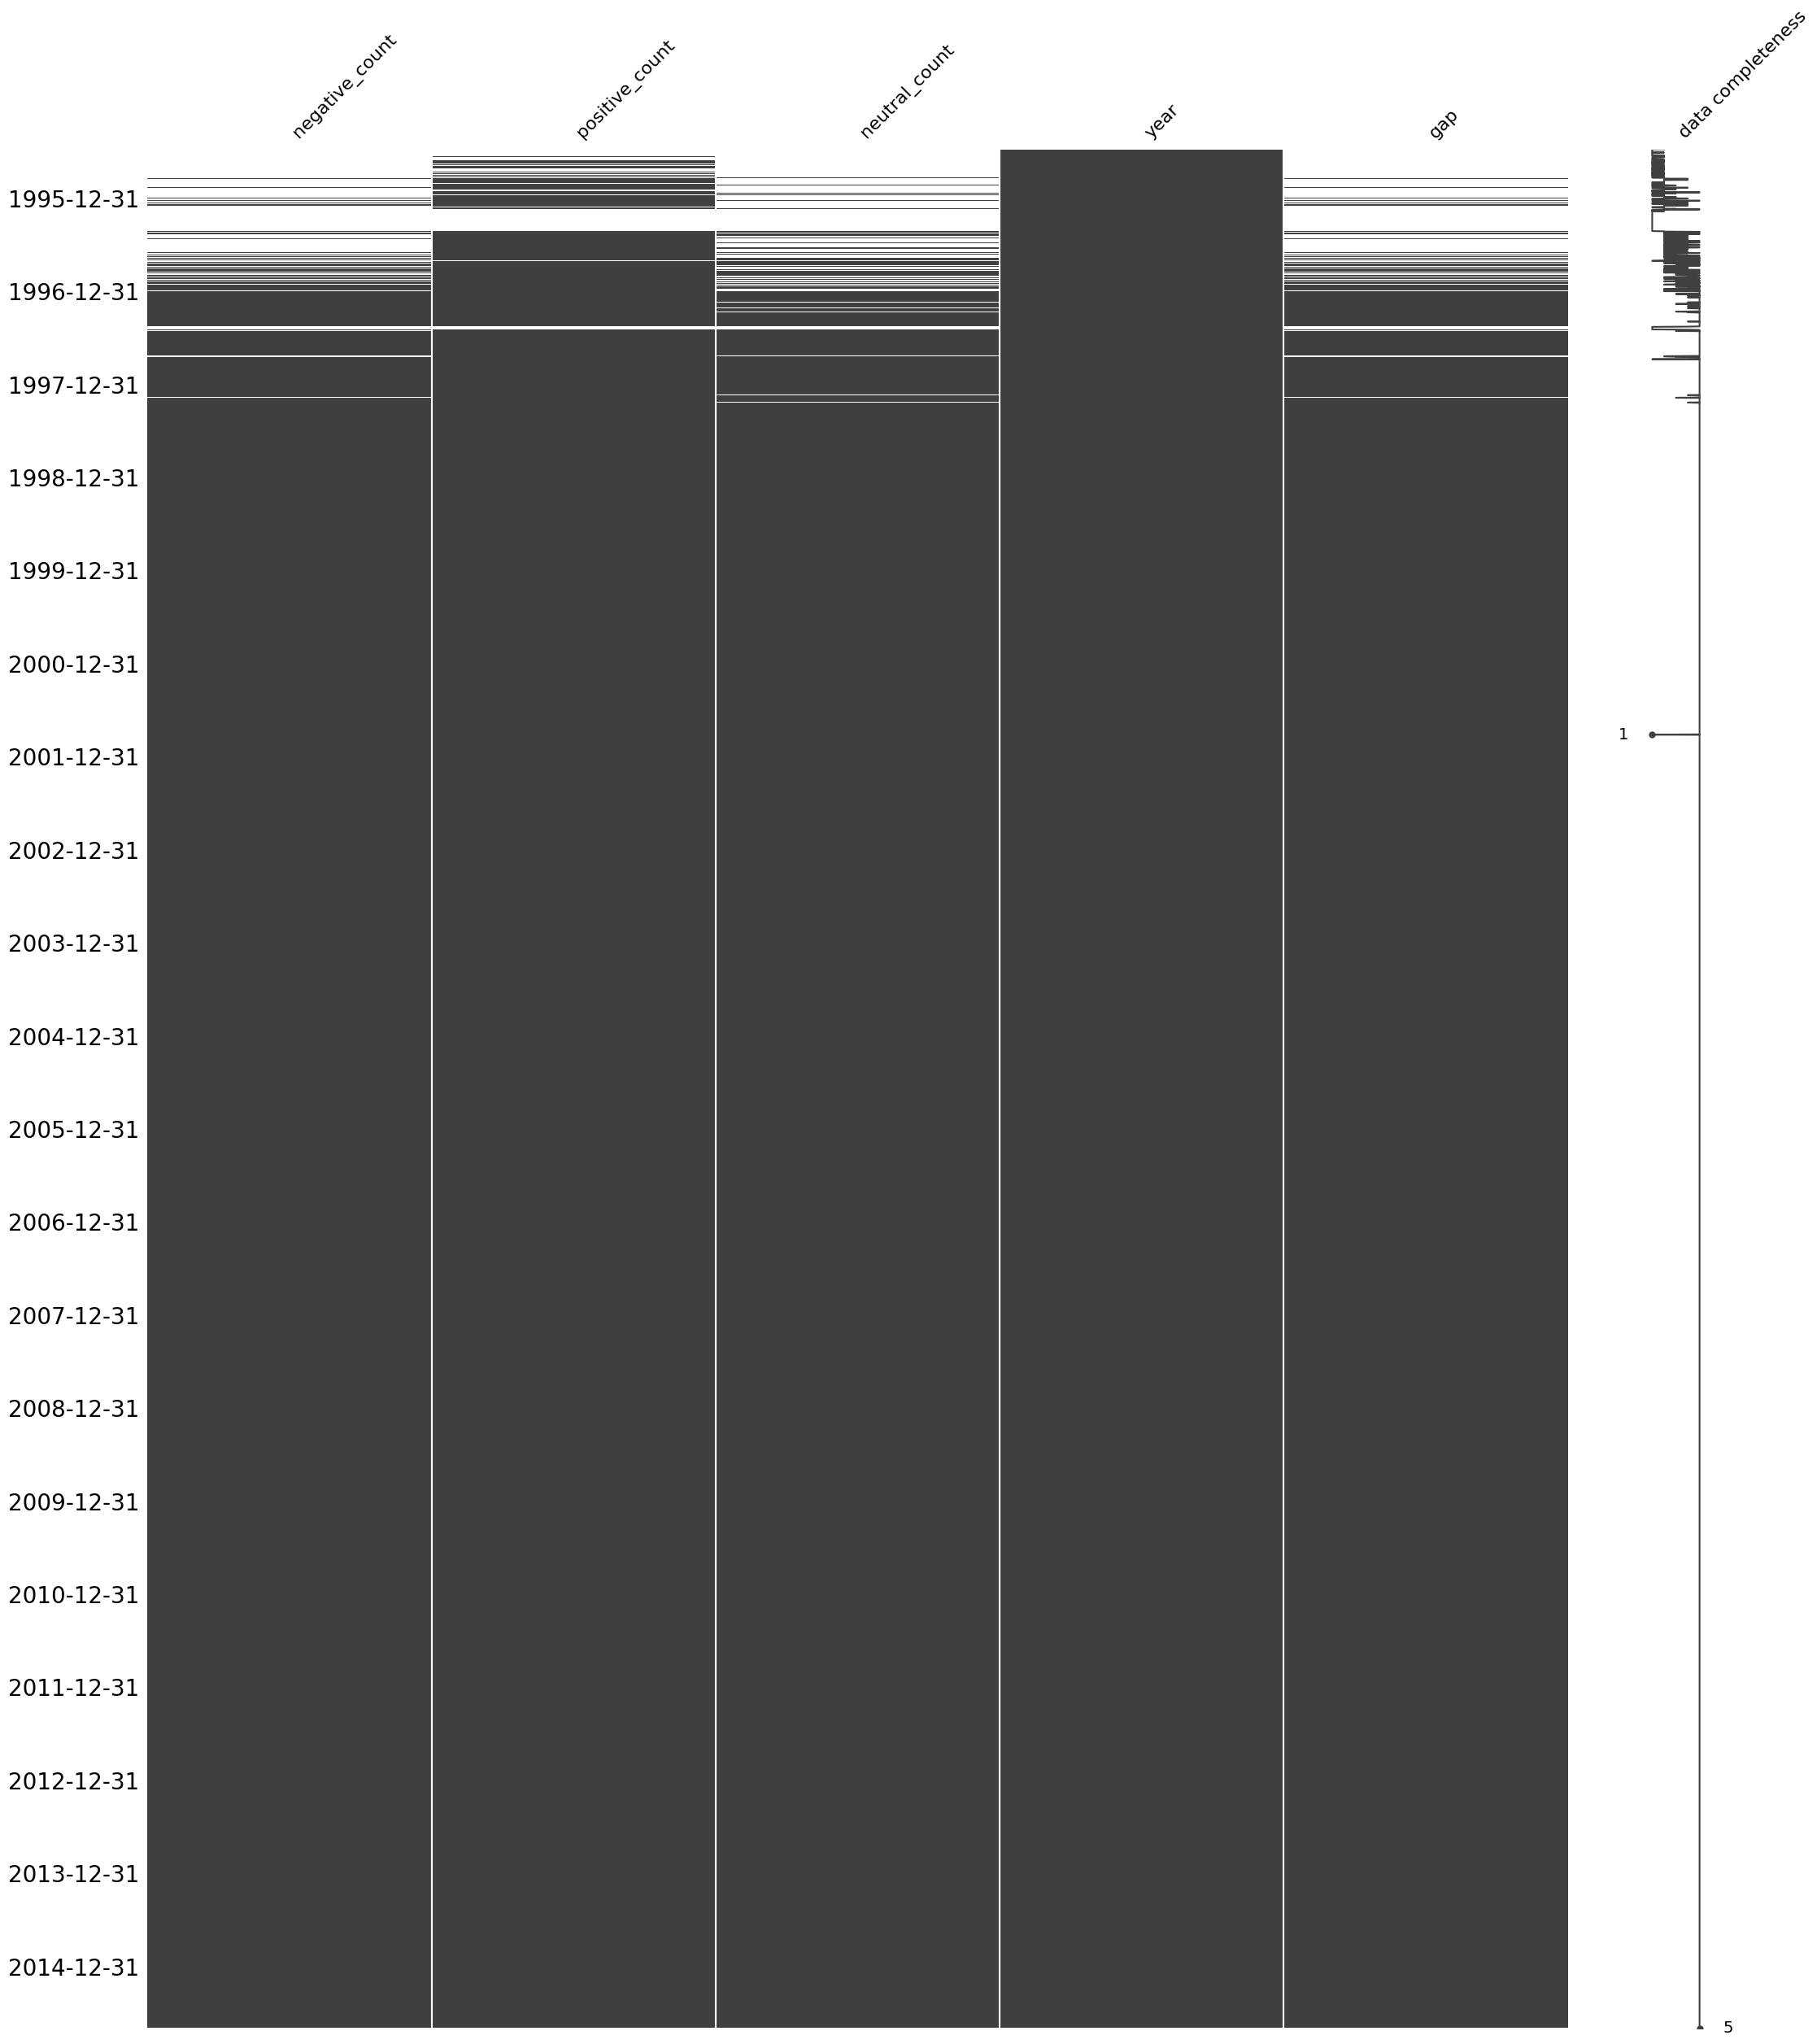

In [8]:
msno.matrix(df, labels=True, freq="YE", figsize=(25, 30))

In [9]:
df = df[(df.index > "2001-10-31")]
print(f"Number of rows with missing values: {df.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


## Análisis de serie de tiempo 


In [10]:
fig_line = px.line(
    df,
    x=df.index,
    y="gap",
    color="year",
    title="Review gap time series",
)

# Mostrar el gráfico
fig_line.show()

In [11]:
fig_boxplot = px.box(
    df,
    x="year",
    y="gap",
    color="year",
    title="Gap difference in reviews",
)

# Mostrar el gráfico
fig_boxplot.show()

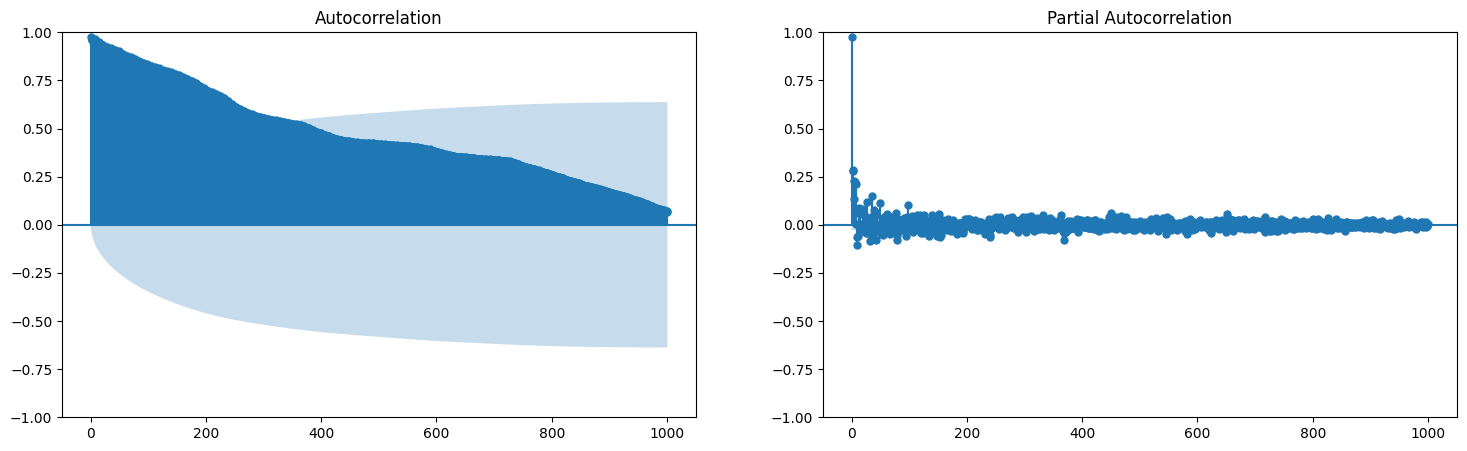

In [12]:
plot_acf_pacf(df, variable=["gap"], lags=1000)

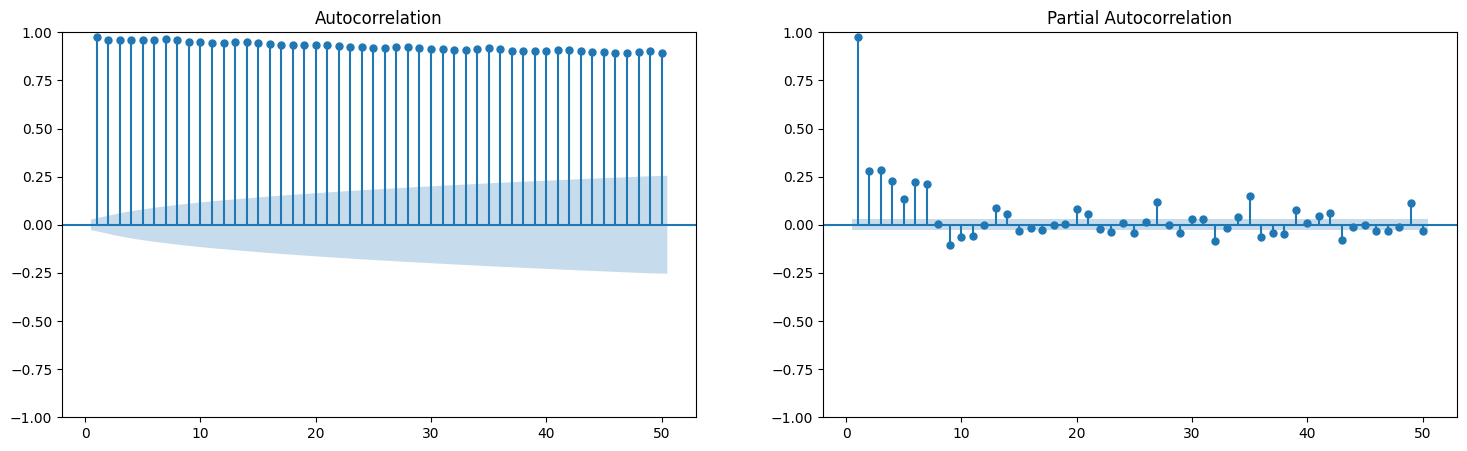

In [13]:
plot_acf_pacf(df, variable=["gap"], lags=50)

Se evidencia frecuencias en el test de autocorrelación de manera visual en aproximadamente cada 200 lags.

en el PACF se evidencia una alta correlación del primer lag con su valor pasado, y esto persiste hsata el septimo lag, tiene sentido pues estamos trabajando con registros diarios.

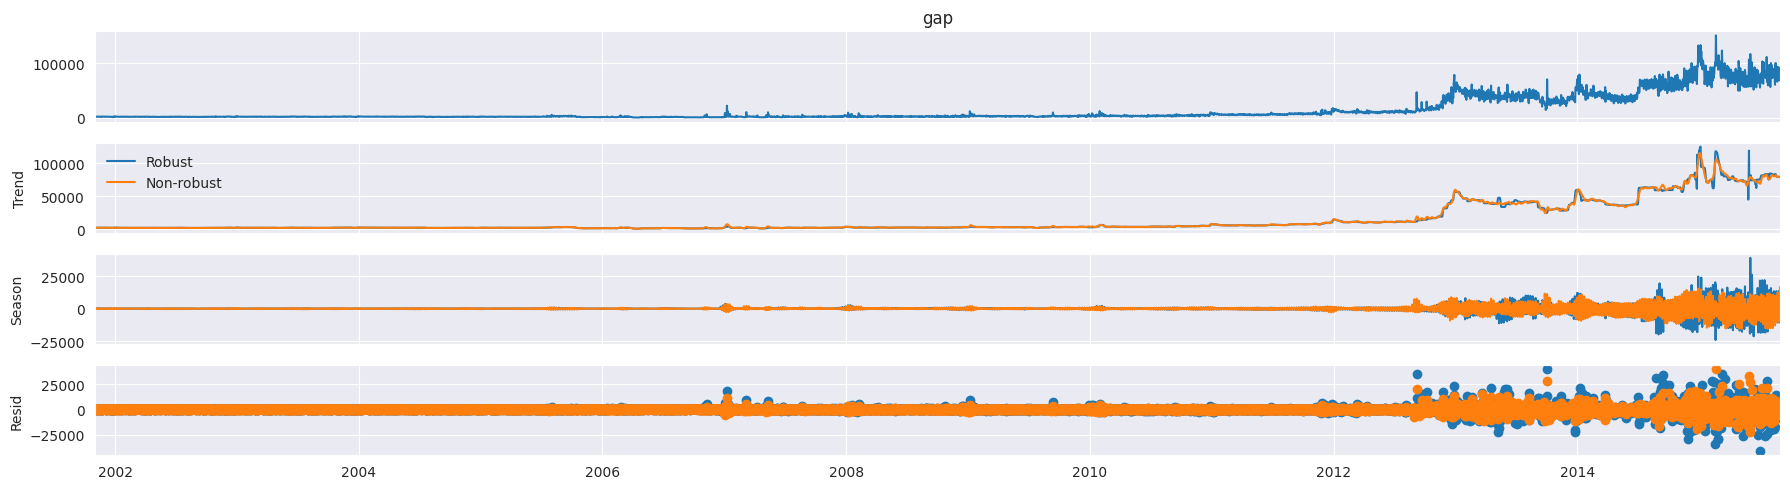

In [14]:
sns.set_style("darkgrid")
stl = STL(df["gap"], period=None, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()

res_non_robust = STL(df["gap"], period=None, robust=False)
stl_non_robust = res_non_robust.fit()
add_stl_plot(
    fig,
    stl_non_robust,
    ["Robust", "Non-robust"],
)

In [15]:
print(stl.config)
print(res_non_robust.config)

{'period': 7, 'seasonal': 7, 'seasonal_deg': 1, 'seasonal_jump': 1, 'trend': 15, 'trend_deg': 1, 'trend_jump': 1, 'low_pass': 9, 'low_pass_deg': 1, 'low_pass_jump': 1, 'robust': True}
{'period': 7, 'seasonal': 7, 'seasonal_deg': 1, 'seasonal_jump': 1, 'trend': 15, 'trend_deg': 1, 'trend_jump': 1, 'low_pass': 9, 'low_pass_deg': 1, 'low_pass_jump': 1, 'robust': False}


# Log de gap

In [21]:
df["gap_log"] = np.log(df["gap"])

## Split de la data

In [22]:
temp_df, test_df = split_data_into_train_test(df, test_size=30)
train_df, validation_df = split_data_into_train_test(temp_df, test_size=30)

In [23]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_df.index, y=train_df["gap"], mode="lines", name="Train")
)
fig.add_trace(
    go.Scatter(
        x=validation_df.index, y=validation_df["gap"], mode="lines", name="Validation"
    )
)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df["gap"], mode="lines", name="Test"))

# Configurar el título y las etiquetas
fig.update_layout(
    title="Monthly Fuel Consumption in Spain", xaxis_title="Date", yaxis_title="Gap"
)

# Mostrar el gráfico
fig.show()

Skforecast version:  0.12.1
Test stationarity for original series
-------------------------------------


/home/camilo/proyecto-integrador-semestre-2/notebooks/time_series/utils.py:108: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




ADF Statistic: -0.5283258642907859, p-value: 0.8863693642827841
KPSS Statistic: 6.482287221771573, p-value: 0.01
Number of lags used: 4960

Test stationarity for differenced series (order=1)
--------------------------------------------------


/home/camilo/proyecto-integrador-semestre-2/notebooks/time_series/utils.py:116: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




ADF Statistic: -14.984985937606758, p-value: 1.1473569785380097e-27
KPSS Statistic: 0.10523523172001323, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------


/home/camilo/proyecto-integrador-semestre-2/notebooks/time_series/utils.py:123: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




ADF Statistic: -20.469437313402832, p-value: 0.0
KPSS Statistic: 0.02611225102070399, p-value: 0.1


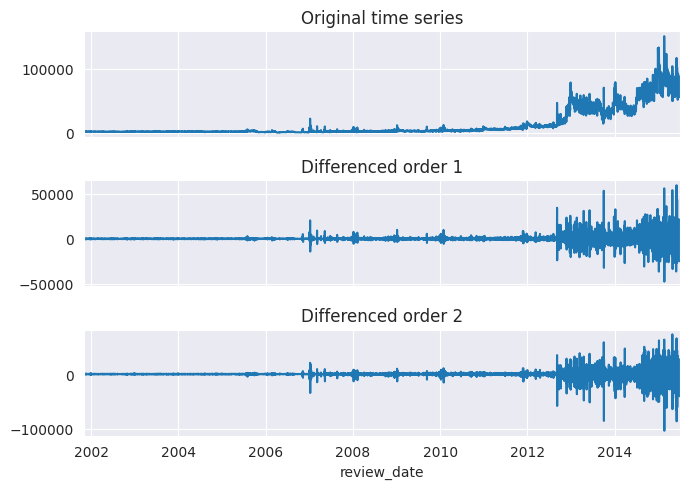

In [25]:
test_stationarity_and_plot(train_df, "gap")

## Interpretación de los Resultados de Estacionaridad

Para interpretar los resultados de las pruebas de Dickey-Fuller Aumentado (ADF) y KPSS, es importante entender las hipótesis que cada prueba evalúa:

#### Prueba ADF (Dickey-Fuller Aumentado):

Hipótesis nula (𝐻0): La serie tiene una raíz unitaria (no es estacionaria).
Hipótesis alternativa (𝐻1): La serie no tiene una raíz unitaria (es estacionaria).
Un valor p bajo (< 0.05) indica que podemos rechazar 𝐻0 y concluir que la serie es estacionaria.

#### Prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin):

Hipótesis nula (𝐻0): La serie es estacionaria.
Hipótesis alternativa (𝐻1): La serie no es estacionaria.
Un valor p bajo (< 0.05) indica que podemos rechazar 𝐻0 y concluir que la serie no es estacionaria.

## Resultados
### Serie Original
ADF:

    ADF Statistic: -0.5283
    p-value: 0.8864

KPSS:

    KPSS Statistic: 6.4823
    p-value: 0.01

### Interpretación:

    -La prueba ADF tiene un valor p alto (0.8864), por lo que no podemos rechazar la hipótesis nula de que la serie no es estacionaria..
    -La prueba KPSS tiene un valor p bajo (0.01), por lo que rechazamos la hipótesis nula de que la serie es estacionaria.
    -Ambas pruebas sugieren que la serie original no es estacionaria.

## Serie Diferenciada (Orden 1)
ADF:

    ADF Statistic: -14.9850
    p-value: 1.147e-27

KPSS:

    KPSS Statistic: 0.1052
    p-value: 0.1

### Interpretación:

    -La prueba ADF tiene un valor p extremadamente bajo (1.147e-27), por lo que rechazamos la hipótesis nula de que la serie no es estacionaria. Esto sugiere que la serie diferenciada es estacionaria.
    -La prueba KPSS tiene un valor p relativamente alto (0.1), por lo que no podemos rechazar la hipótesis nula de que la serie es estacionaria.
    -Ambas pruebas sugieren que la serie diferenciada de primer orden es estacionaria.

## Serie Diferenciada (Orden 2)
ADF:

    ADF Statistic: -20.469
    p-value: 0.0

KPSS:

    KPSS Statistic: 0.0261
    p-value: 0.1

### Interpretación:

    -La prueba ADF tiene un valor p de 0, indicando claramente que la serie diferenciada de segundo orden es estacionaria.
    -La prueba KPSS tiene un valor p alto (0.1), lo que sugiere que no podemos rechazar la hipótesis nula de que la serie es estacionaria.
    -Ambas pruebas confirman que la serie diferenciada de segundo orden es estacionaria.

## Conclusión

    -La serie original no es estacionaria según ambas pruebas ADF y KPSS.
    -La serie diferenciada de primer orden es estacionaria.
    -La serie diferenciada de segundo orden también es estacionaria.

En resumen, la diferenciación de primer orden es suficiente para hacer que tu serie sea estacionaria, según ambas pruebas ADF y KPSS. La diferenciación de segundo orden también resulta en una serie estacionaria, pero generalmente, preferimos usar la menor cantidad de diferenciación necesaria para la estacionaridad. Por lo tanto, será utilizada la serie diferenciada de primer orden para el análisis y modelado.

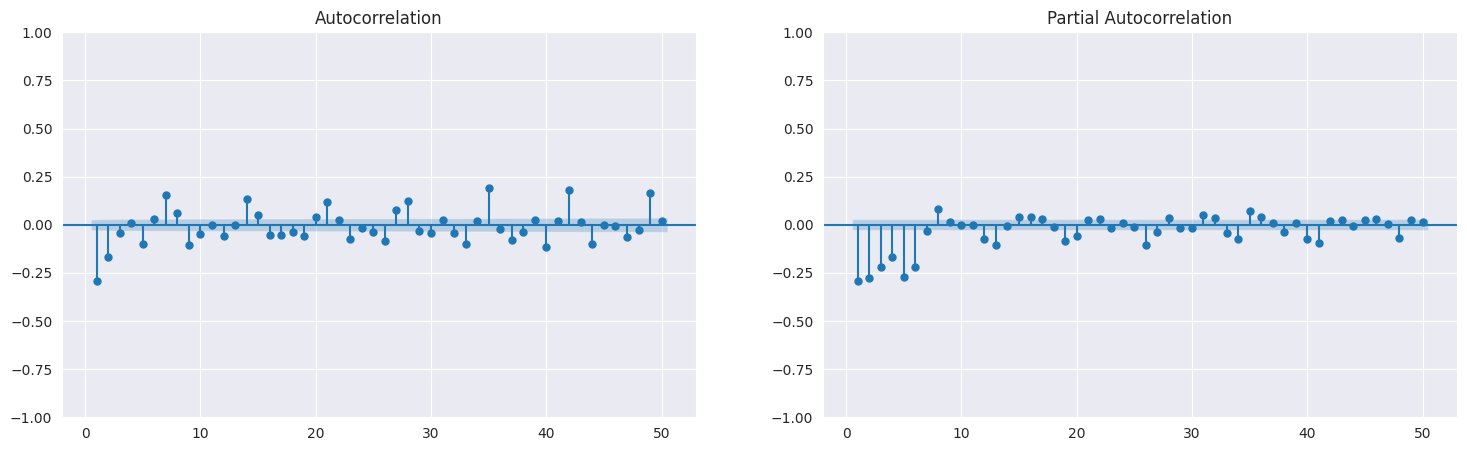

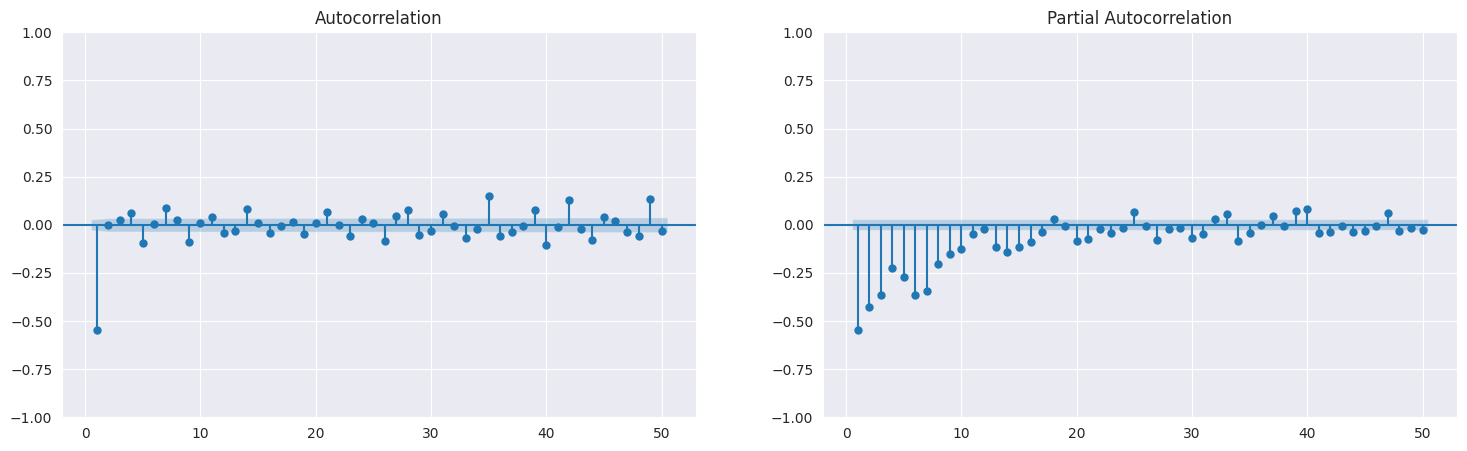

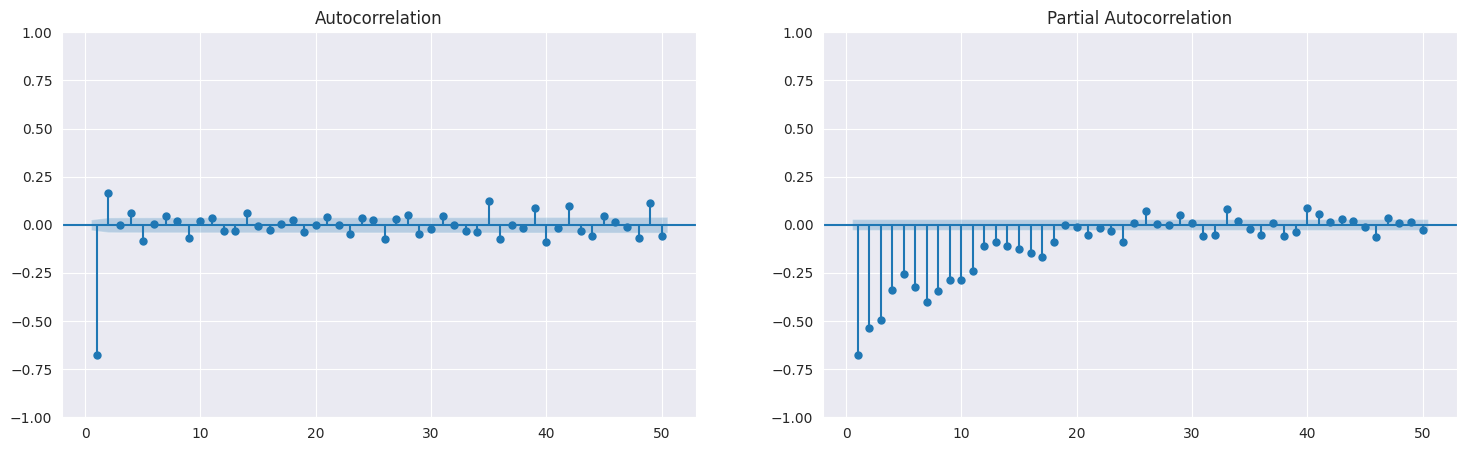

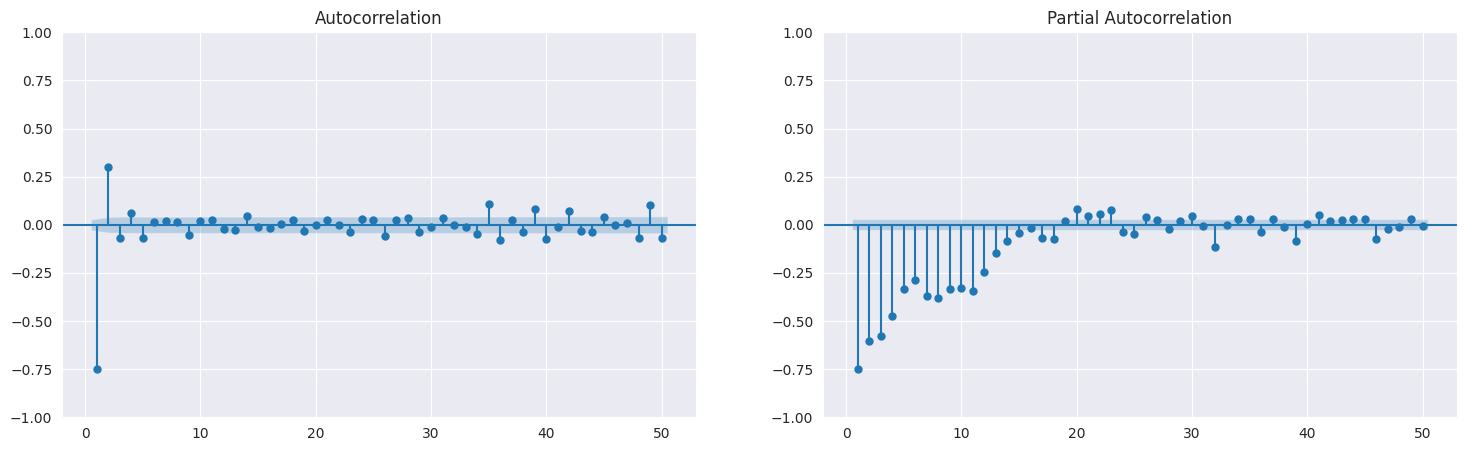

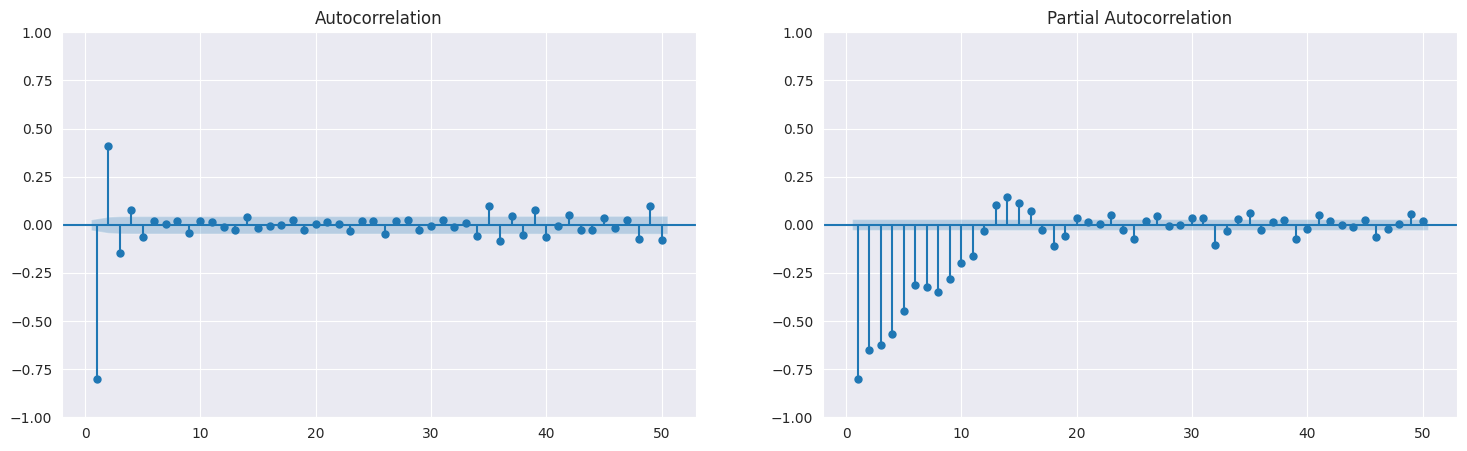

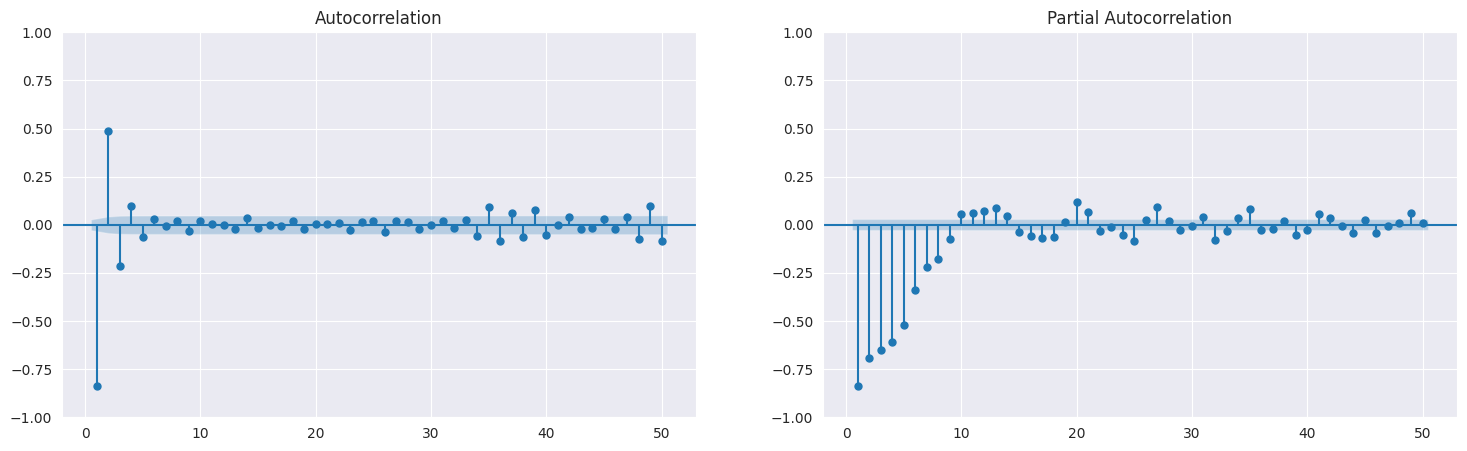

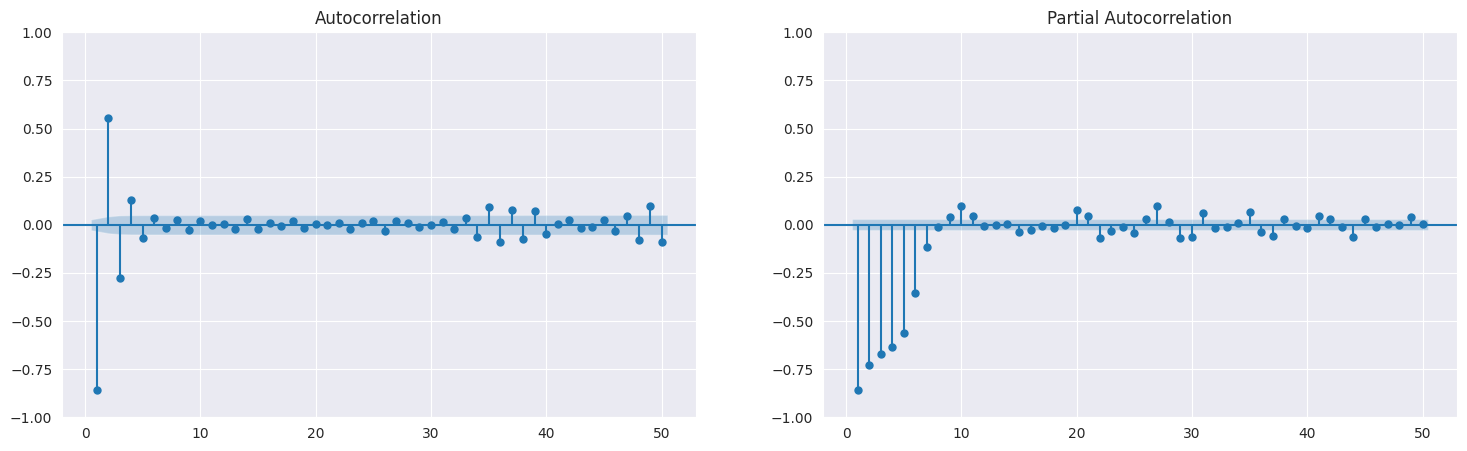

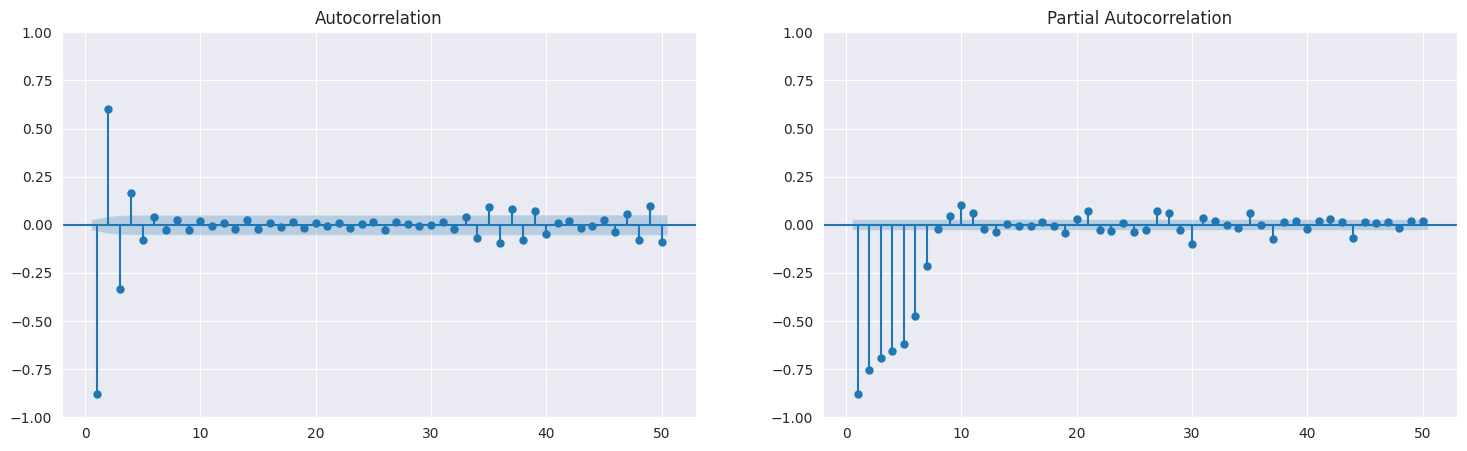

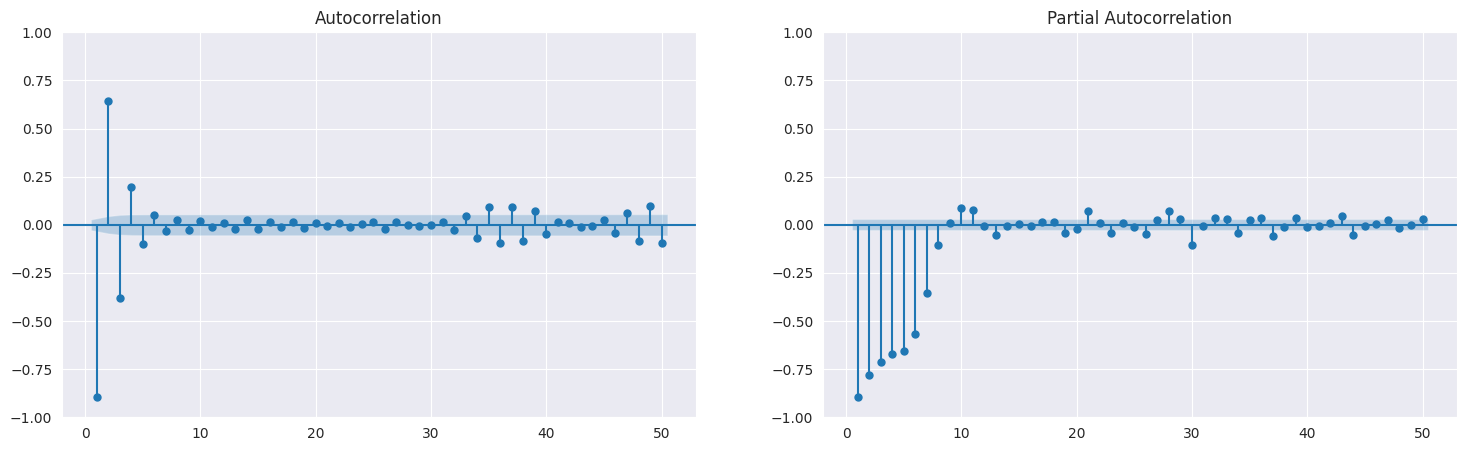

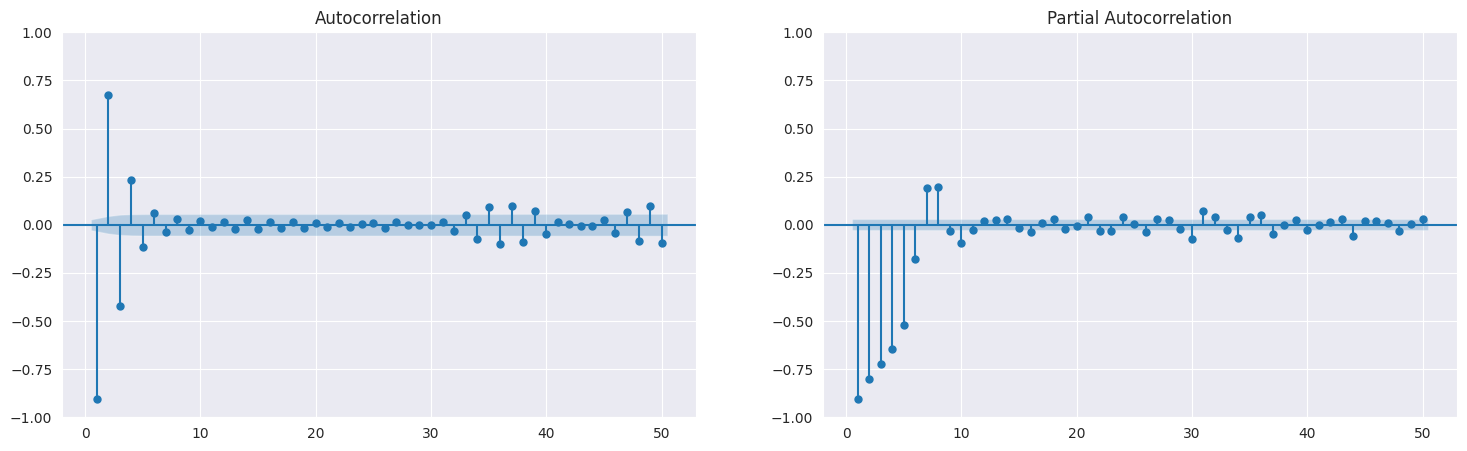

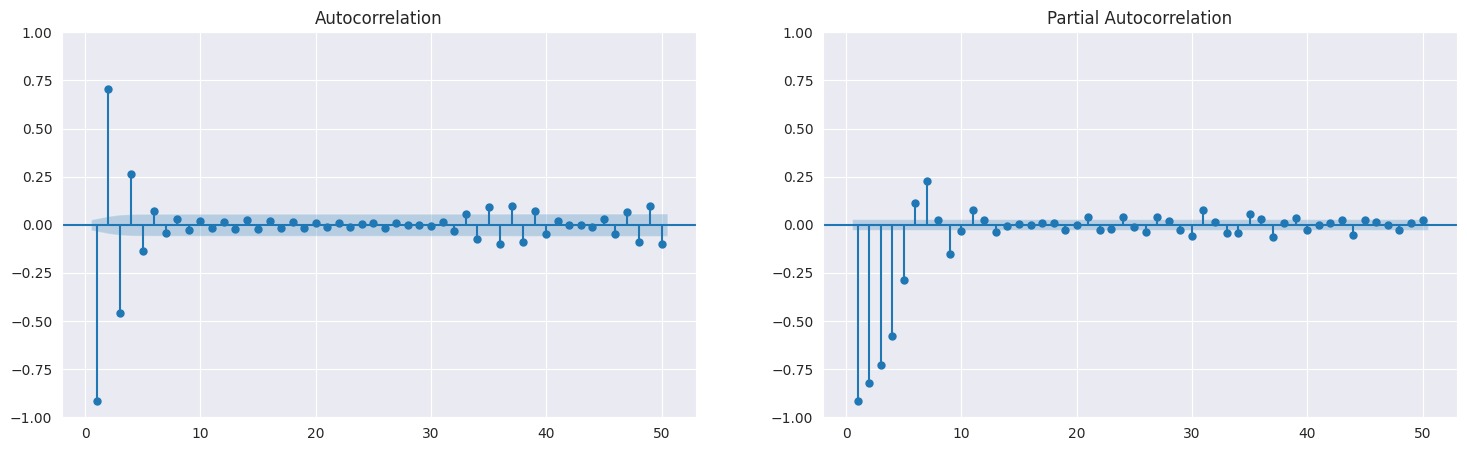

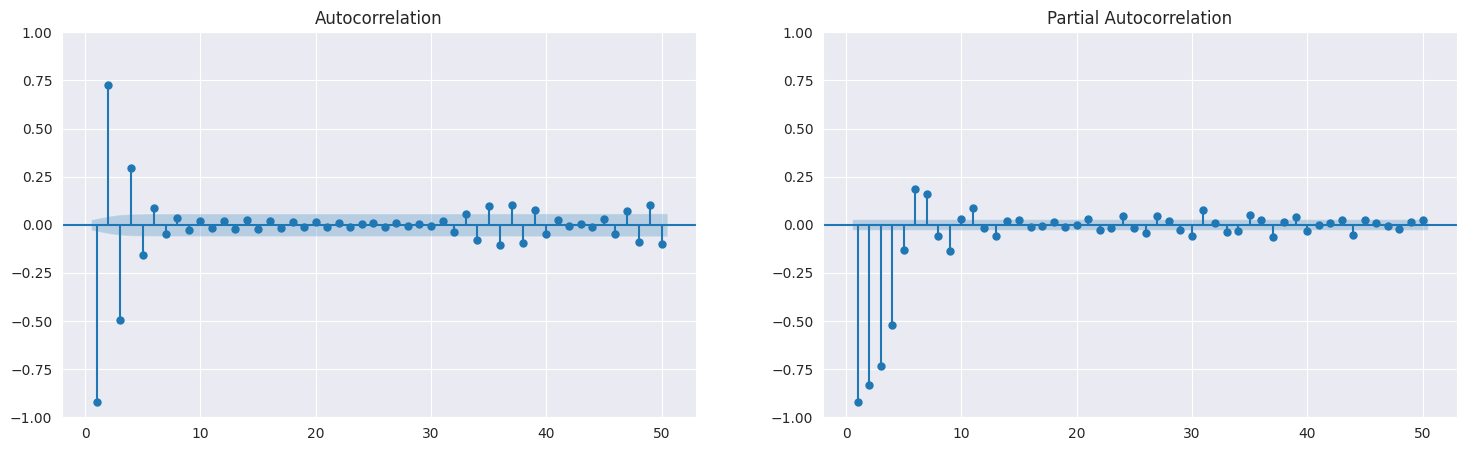

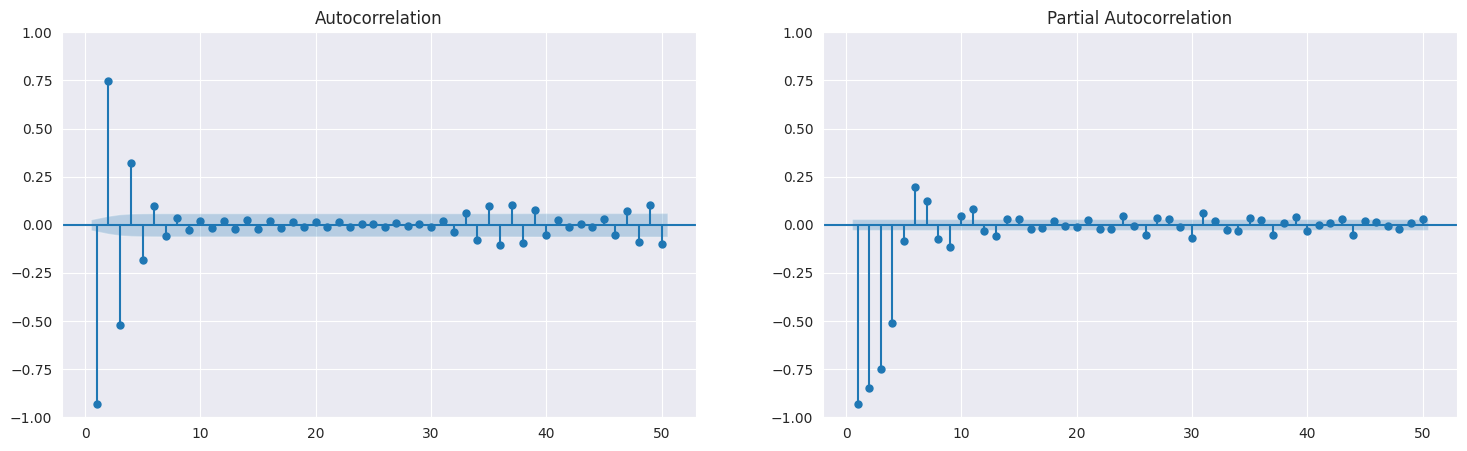

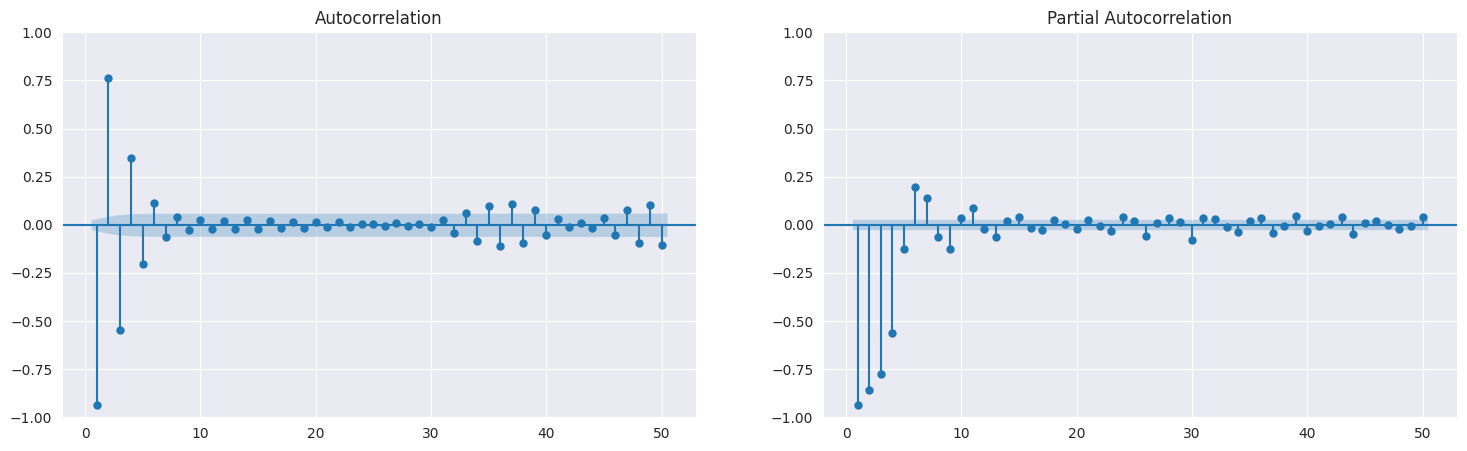

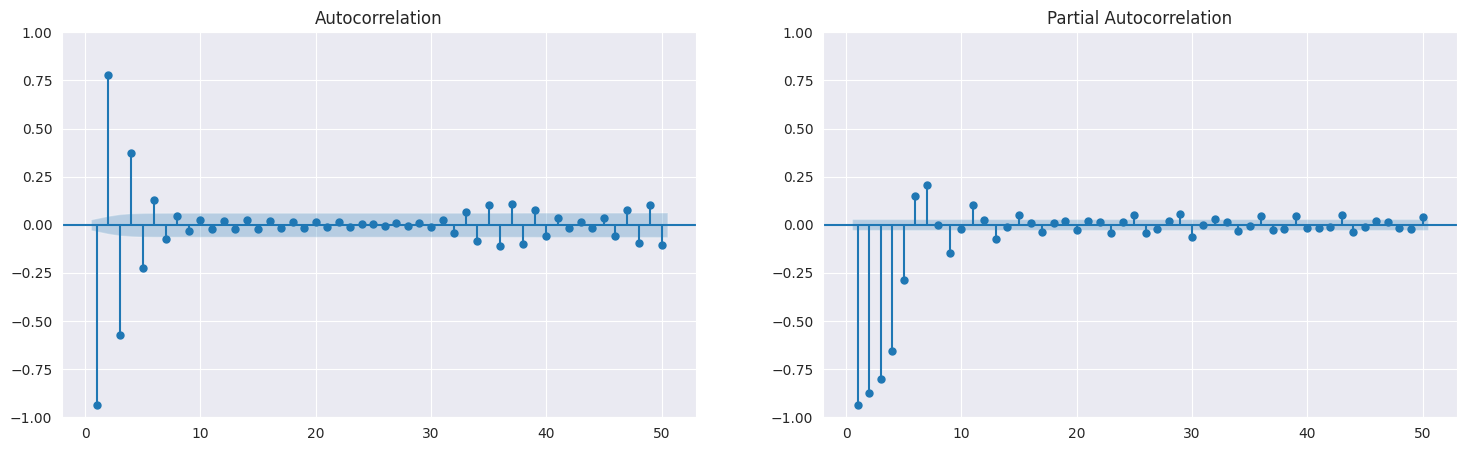

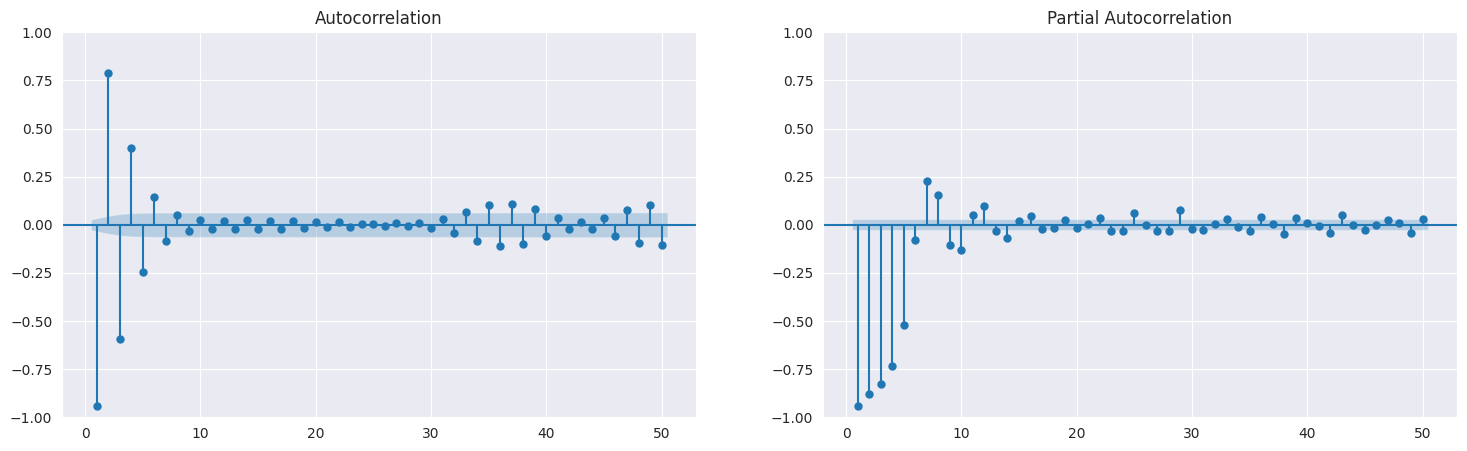

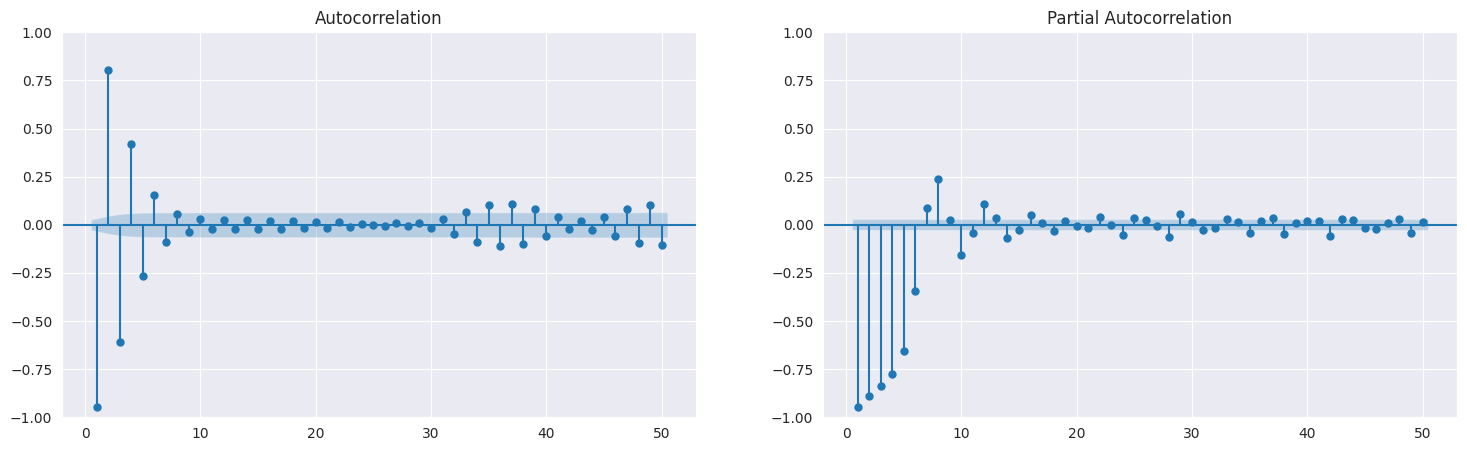

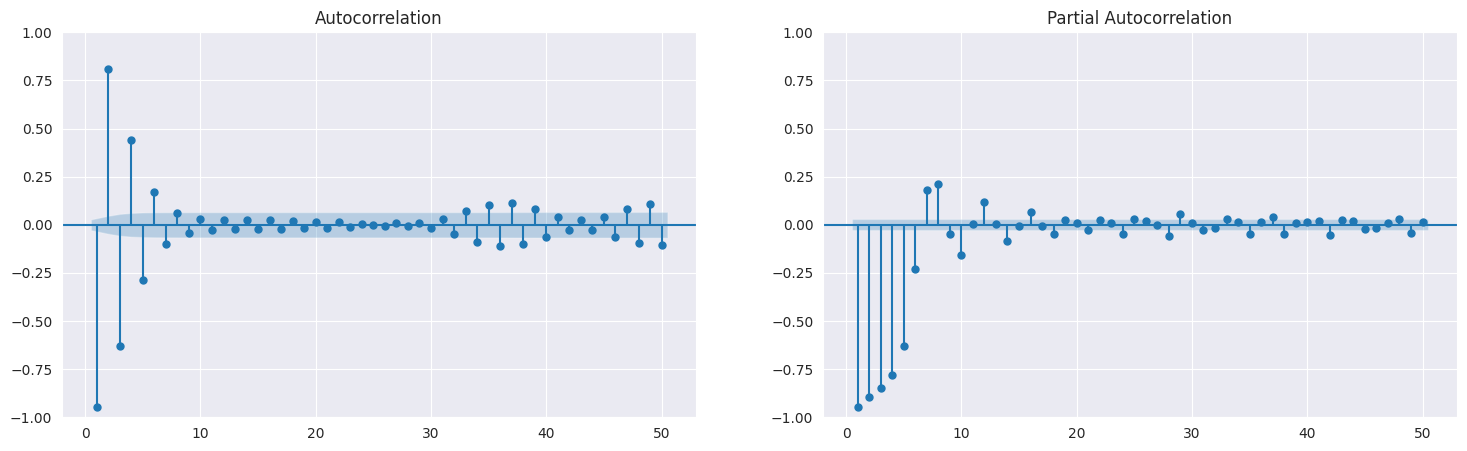

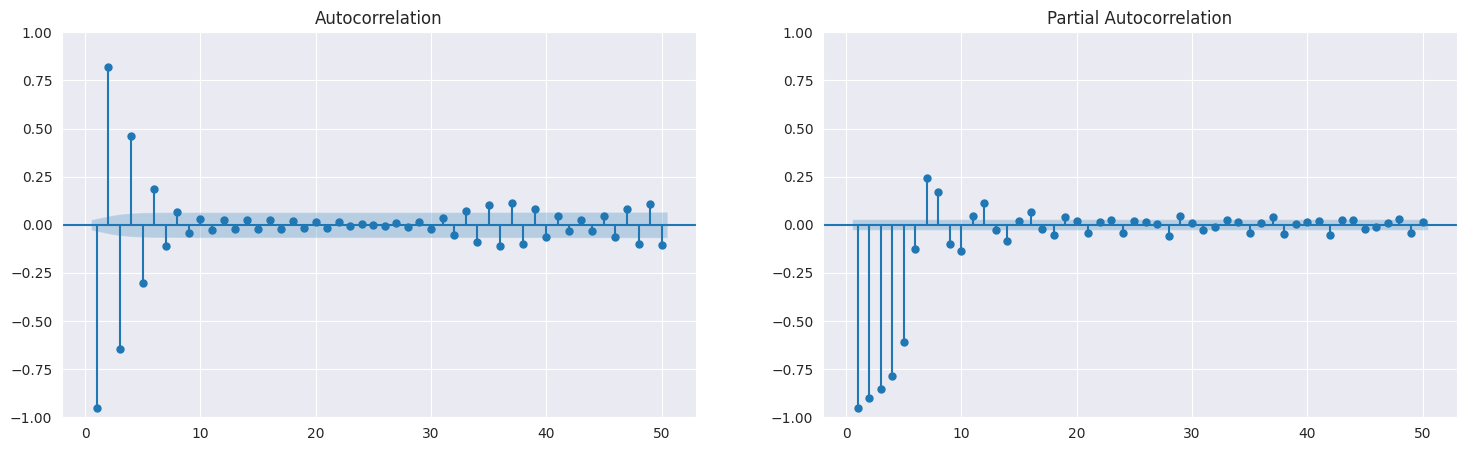

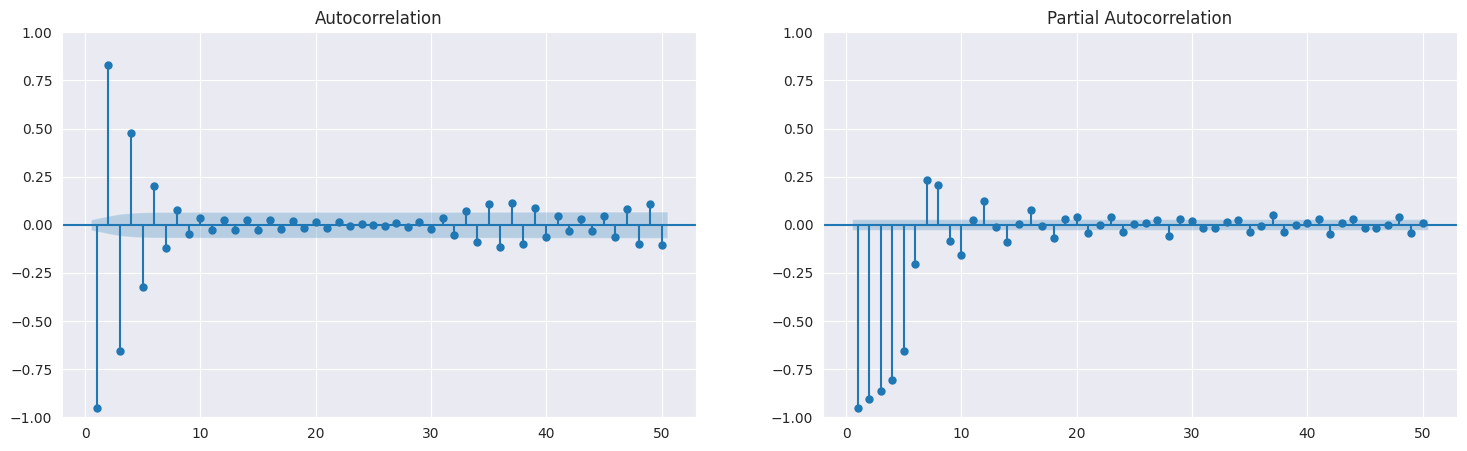

In [19]:
data_diff = np.sqrt(train_df["gap"])
diffs = 20
for i in range(diffs):
    data_diff = data_diff.diff().dropna()
    plot_acf_pacf(data_diff, variable=None, lags=50)

# Exportamos la data sin transformación

In [29]:
train_df.to_parquet("../../data/time_series/train_df.parquet", index=True)
validation_df.to_parquet("../../data/time_series/validation_df.parquet", index=True)
test_df.to_parquet("../../data/time_series/test_df.parquet", index=True)

## Conclusión

no fue posible diferenciar completamente la serie para que sea estacionaria, aunque los tes